# **The Project**

The final project of this lecture is to use the TOX21 dataset that contains molecular `SMILES` and to train a model to able to classify a molecule as toxic or non-toxic.

The `TOX21` Data challenge has been the largest effort of the scientific community to compare computational methods for toxicity prediction. 
[[link]](https://tripod.nih.gov/tox21/challenge/data.jsp#)

Here we provide a bit of help to structure your project:

- Load both the training and test datasets CSV files and explore them
- Build a function that uses RDKit to interpret the SMILE representation present in the CSV files
- From that list of SMILES extrat the Molecular Morgan FingerPrints as representation for the molecule. [[more Help]](https://www.rdkit.org/docs/GettingStartedInPython.html)
- Choose a couple of reasonable models from scikit-learn able to classify does molecules into toxic and non-toxic.
- Train it a assess its performance by classifying the ones in the test set.
- Try to improve the model performance:
    - Cross-validation strategy
    - Hyperparameter optimization

In [1]:
# Import libraries here
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import IPython.core.display
from IPython.display import HTML

## 1.0 Load CSV files

In [2]:
# Load CSV files with pandas
tox_train = pd.read_csv("./datasets/tox21_train.csv")
tox_test = pd.read_csv("./datasets/tox21_test.csv")

tox_train.head()

,id,smile,target
0,NCGC00167516-01,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,0
1,NCGC00181091-01,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,1
2,NCGC00094089-01,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,1
3,NCGC00094996-01,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,1
4,NCGC00257773-01,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,0


In [3]:
# Convert df smile and target as lists
smile_list = tox_train["smile"].tolist()
target_list = tox_train["target"].tolist()

## 2.0 Helper functions

Build the funstions to convert from smile to rdkit molecule object and to extract the Morgan Fingerprints out of that molecule object. In two different functions.

In [4]:
# We need a function that converts smile to rdkit molecule and get their fingerprints

def _smile_2_mol(smile):
    """Helper function to convert smile to rdkit mol"""
    m = Chem.MolFromSmiles(smile)
    return m

def _morgan_representation(mol, radius=6):
    """Helper function to convert smile to morgan finger prints"""
    fpgen = AllChem.GetMorganGenerator(radius=radius)
    fp = fpgen.GetFingerprint(mol)
    return np.array(fp)

def _save_model(model, filename="./best_model.pkl"):
    """Helper function to save a model into a pickle file"""
    with open(filename, "wb") as p_file:
        pickle.dump(model, p_file)
    p_file.close()
    return

def _load_model(filename):
    """Helper function load a ml model from pickle file"""
    with open(filename, "rb") as p_file:
        model = pickle.load(p_file)
    p_file.close()
    return model

## 3.0 Process the training data

Now use the previuous function to actually convert the dataset into Morgan fingerprints and store the representation and target in a dictionary.

In [5]:
# Collect fingerprint and target as dict
dataset = {"rep": [], "target": []}

for idx, (smile, target) in enumerate(zip(smile_list, target_list)):
    try:
        # Convert smile to mol
        mol = _smile_2_mol(smile)
        # From mol to FP
        fp = _morgan_representation(mol)
        # Append
        dataset["rep"].append(fp)
        dataset["target"].append(target)

    except:
        print("invalid molecule")

[12:31:22] Explicit valence for atom # 3 Si, 8, is greater than permitted


invalid molecule


[12:31:22] Explicit valence for atom # 0 Cl, 2, is greater than permitted


invalid molecule


[12:31:23] Explicit valence for atom # 2 Cl, 2, is greater than permitted


invalid molecule


[12:31:24] WARNING: not removing hydrogen atom without neighbors
[12:31:25] Explicit valence for atom # 3 Si, 8, is greater than permitted


invalid molecule


In [6]:
# Arrays for input and target
x_tox21 = np.array(dataset["rep"])
y_tox21 = np.array(dataset["target"])

## 4.0 Train the model

Implement the code to train a given model using `KFold` strategy and to save the best model as pickle file.

In [7]:
# In this case, we are gonna use logistic regressor as the model
from sklearn.model_selection import train_test_split, KFold, cross_val_score

scores = []
kfold = KFold(n_splits=10)
best_score = 0
for idx, (train_index, test_index) in enumerate(kfold.split(x_tox21)):
    # Lower case to differenciate between X and x
    x_train, x_test, y_train, y_test = x_tox21[train_index], x_tox21[test_index], y_tox21[train_index], y_tox21[test_index]

    # Initialize model
    lr = LogisticRegression(max_iter=300)

    # Fit the model
    lr.fit(x_train, y_train)

    # Score
    k_score = lr.score(x_test, y_test)

    # Store scores
    scores.append(k_score)
    print(f"Kfold: {idx} has a score of {k_score}")

    # Store model
    if k_score > best_score:
        # Update score
        best_score = k_score
        # Save the model
        print("Saving model...")
        _save_model(lr, filename="./best_model.pkl")
        

# The scores' mean
print(f"The score's mean is {np.mean(scores)}")

Kfold: 0 has a score of 0.9188034188034188
Saving model...
Kfold: 1 has a score of 0.9305555555555556
Saving model...
Kfold: 2 has a score of 0.9252136752136753
Kfold: 3 has a score of 0.905982905982906
Kfold: 4 has a score of 0.9572649572649573
Saving model...
Kfold: 5 has a score of 0.969017094017094
Saving model...
Kfold: 6 has a score of 0.9775641025641025
Saving model...
Kfold: 7 has a score of 0.9807692307692307
Saving model...
Kfold: 8 has a score of 0.9786096256684492
Kfold: 9 has a score of 0.9893048128342246
Saving model...
The score's mean is 0.9533085378673615


## 5.0 Process the test data for TOX21

Do the same as you did for the training dataset but for the test dataset, so you can see the actual accuracy of your model in this new dataset

In [8]:
# Convert df smile and target as lists
smile_test_list = tox_test["smile"].tolist()
target_test_list = tox_test["target"].tolist()

# Build the test dataset as a dict
dataset_test = {"rep": [], "target": []}

for idx, (smile, target) in enumerate(zip(smile_test_list, target_test_list)):
    try:
        # Convert smile to mol
        mol = _smile_2_mol(smile)
        # From mol to FP
        fp = _morgan_representation(mol)
        # Append
        dataset_test["rep"].append(fp)
        dataset_test["target"].append(target)

    except:
        print("invalid molecule")

# Arrays for input and target
x_test_tox21 = np.array(dataset_test["rep"])
y_test_tox21 = np.array(dataset_test["target"])

## 6.0 Load the best model

Load the best model using the `_load_model` function and assess the accuracy of your model with test dataset

In [9]:
# Best model
model = _load_model(filename="./best_model.pkl")
print(model)

LogisticRegression(max_iter=300)


In [10]:
# Performance
y_pred = model.predict(x_test_tox21)

print(f"The accuracy is {accuracy_score(y_pred, y_test_tox21)}")

The accuracy is 0.9448275862068966


## 7.0 Play with your model!

Use your model to predict whether caffefine and Pentaclorophenol is a toxic molecule or not!

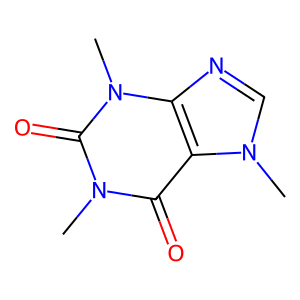

In [11]:
# Caffeine
caffeine = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
caff_img = Draw.MolToImage(caffeine)
display(caff_img)

In [12]:
# Convert mol to Finger prints
caff_fp = _morgan_representation(caffeine)

# Predict value
caff_tox = model.predict(caff_fp.reshape(1, caff_fp.shape[0]))[0]

if caff_tox == 0:
    print("Caffeine is non-toxic!")
else:
    print("Caffeine is toxic!")

Caffeine is non-toxic!


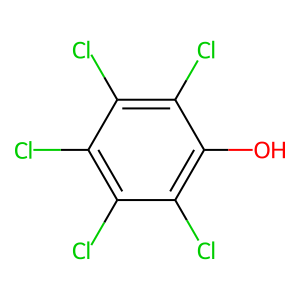

In [13]:
cloro_phenol = Chem.MolFromSmiles("C1(=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl)O")
cloro_phenol_img = Draw.MolToImage(cloro_phenol)
display(cloro_phenol_img)

In [14]:
# Convert mol to Finger prints
cloro_phenol_fp = _morgan_representation(cloro_phenol)

test = cloro_phenol_fp.reshape(1, cloro_phenol_fp.shape[0])

# Predict value
cloro_phenol_tox = model.predict(cloro_phenol_fp.reshape(1, cloro_phenol_fp.shape[0]))

if cloro_phenol_tox == 0:
    print("Pentaclorophenol is non-toxic!")
else:
    print("Pentaclorophenol is toxic!")

Pentaclorophenol is toxic!


Use this model to predict the toxicity of a molecular that you normally use in your lab!